In [1]:
#jax bisher nur für CPU intslliert (pip install -U "jax[cpu]")
import jax.numpy as jnp
import jax.lax as lax
from jax import jit, vmap
from functools import partial
from matplotlib import pyplot as plt
from scipy import constants as const
import timeit

# Plot-Formatierung
plt.rcParams['font.size'] = 24.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0

G = const.G / (3.0857E+16)**3 * 1.989E+30 * (3.0857E+13)**2 #impurity ist ok (G ist konstant über die Auswertung)
                            #Umrechnung in pc^3/M_sun/s^2 (grav pot in (km/s)^2)
                            #Umrechnung, sodass z in parsec

#Formulierung des Anfangswertproblems (z taucht in den Formeln auf, um an anderen DGLs zu testen)
f = lambda roh_dm, params, z, u: jnp.array([u[1], \
            4*jnp.pi*G * (jnp.sum(params[:,0]*jnp.exp(-u[0]/params[:,1]**2)) + roh_dm)])
z0 = 0.
u0 = jnp.array([0.,0.]) #freie Nullpunktswahl/Symmetrie
roh_dm = 0.025 #M_sun/pc^3
params = jnp.array([[0.021, 4.], [0.016, 7.], [0.012, 9.], \
                    [0.0009, 40.], [0.0006, 20.], [0.0031, 7.5], \
                    [0.0015, 10.5], [0.0020, 14.], [0.0022, 18.], \
                    [0.007, 18.5], [0.0135, 18.5], [0.006, 20.], \
                    [0.002, 20.], [0.0035, 37.], [0.0001, 100.]]) 
                                                        #mu(0) ??? in M_sun/pc^3, sigma(0) in km/s

In [25]:
#Routinen

# jit(step)
@partial(jit, static_argnames=['f', 'n'])
def eigenerSolverV1(roh_dm, params, z0, u0, f, n, dz):
                                                          
    # Runge-Kutta 4. Ordnung
    @partial(jit, static_argnames=['f']) #nötig ??
    def rk4_step(roh_dm, params, z0, u0, dz, f):
        k1 = dz * f(roh_dm, params, z0, u0)
        k2 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k1 / 2)
        k3 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k2 / 2)
        k4 = dz * f(roh_dm, params, z0 + dz, u0 + k3)
        u1 = u0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return u1
    
    uz = []

    for i in range(n):
        u0 = rk4_step(roh_dm, params, z0+i*dz, u0, dz, f)
        uz.append(u0)

    return uz

# lax.scan(step)
@partial(jit, static_argnames=['f', 'n']) 
def eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz):
                                                          
    # Runge-Kutta 4. Ordnung
    @partial(jit, static_argnames=['f']) #nötig ??
    def rk4_step(roh_dm, params, z0, u0, dz, f):
        k1 = dz * f(roh_dm, params, z0, u0)
        k2 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k1 / 2)
        k3 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k2 / 2)
        k4 = dz * f(roh_dm, params, z0 + dz, u0 + k3)
        u1 = u0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return u1

    def rk4_step_scan(u, i):
        return rk4_step(roh_dm, params, z0+i*dz, u, dz, f), \
            rk4_step(roh_dm, params, z0+i*dz, u, dz, f)

    _, uz = lax.scan(rk4_step_scan, u0, jnp.linspace(0, n*dz, n))

    return uz

# neu mit diffrax
from diffrax import diffeqsolve, Dopri5, Tsit5, Dopri8, ODETerm, SaveAt, PIDController, DirectAdjoint, ImplicitAdjoint

# Dopri5
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri5(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

#DirectAdjoint
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri5A(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller, 
                    adjoint= DirectAdjoint())

    zs = sol.ts
    uz = sol.ys

    return uz

#ImplicitAdjoint
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri5I(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri5()
    #saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    def sol_step(u,i):
        sol = diffeqsolve(term, solver, t0=z0+i*dz, t1=z0+(i+1)*dz, dt0=dz, y0=u,
                        args=(roh_dm, params),
                    saveat=SaveAt(t1=True),
                    stepsize_controller=stepsize_controller,
                    adjoint=ImplicitAdjoint())
        return sol.ys[0], sol.ys[0]	

    _, uz = lax.scan(sol_step, u0, jnp.arange(n))

    return uz

# Tsit5
@partial(jit, static_argnames=['f', 'n']) 
def diffraxTsit5(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

# Dopri8
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri8(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri8()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

#final
@partial(jit, static_argnames=['f', 'n']) 
def final(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-7)
    adjoint = DirectAdjoint()

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller,
                    adjoint = adjoint, throw=False)
                    #max_steps=65536)

    zs = sol.ts
    uz = sol.ys

    return uz

In [38]:
# Benchmark

n = 120
dz = 10.

In [41]:
print('diffrax final:')
%time uz = final(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit final(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax final:
CPU times: total: 0 ns
Wall time: 1 ms
173 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
# print('eigener Solver V1:')
# %timeit uz = eigenerSolverV1(roh_dm, params, z0, u0, f, n, dz)

In [39]:
print('eigener Solver V2:')
%time uz = eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz).block_until_ready()
%timeit eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz).block_until_ready()

eigener Solver V2:
CPU times: total: 0 ns
Wall time: 0 ns
23.9 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
print('diffrax Dopri5:')
%time uz = diffraxDopri5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxDopri5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax Dopri5:
CPU times: total: 281 ms
Wall time: 442 ms
177 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
print('diffrax Dopri5(DirectAdjoint):')
%time uz = diffraxDopri5A(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxDopri5A(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax Dopri5(DirectAdjoint):
CPU times: total: 609 ms
Wall time: 788 ms
185 µs ± 613 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
print('diffrax Dopri5(ImplicitAdjoint):')
%time uz = diffraxDopri5I(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxDopri5I(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax Dopri5(ImplicitAdjoint):
CPU times: total: 266 ms
Wall time: 350 ms
455 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
# print('diffrax Tsit5:')
# %time uz = diffraxTsit5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
# %timeit diffraxTsit5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

In [10]:
# print('diffrax Dopri8:')
# %time uz = diffraxDopri8(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
# %timeit diffraxDopri8(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

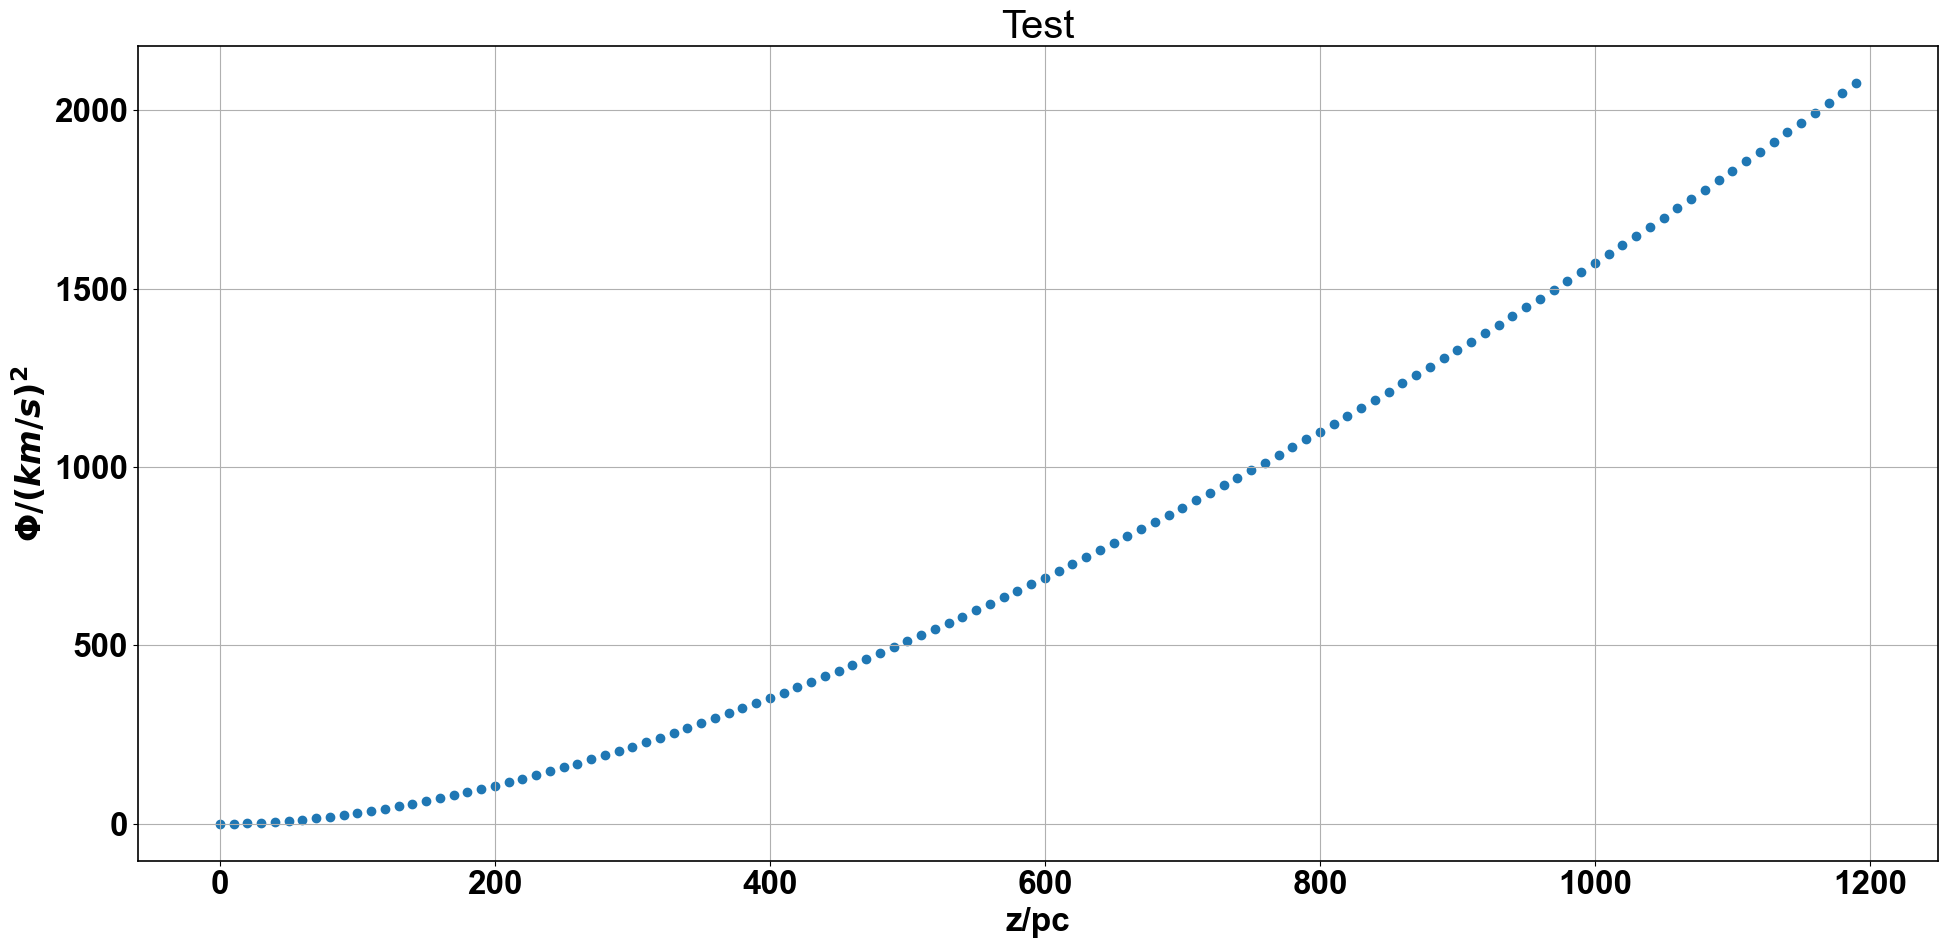

In [42]:
# Plot
fig, ax1 = plt.subplots(figsize=(20,10))
plt.title('Test')
ax1.set_xlabel('z/pc')
ax1.set_ylabel('$\Phi / (km/s)^2$')
ax1.scatter([z0+i*dz for i in range(n)], [u[0] for u in uz], marker='o')
ax1.grid()
fig.tight_layout()